# Интеграция данных

## Цель работы

На практическом примере освоить основные этапы и приемы интеграции разных таблиц данных в единый датасет средствами Python и pandas для последующей подготовки к машинному обучению.

**Содержание работы**
1. Прочитайте три однотипных файла с данными по обращениям клиентов в службу технической поддержки. Познакомьтесь со структурой этих трех таблиц и их особенностями.

2. Объедините три эти таблицы в один общий датасет с максимальным соблюдением внутренней согласованности данных.
3. Прочитайте датасет с данными заказов клиентов, присоедините максимальное количество данных из него к датасету, получившемуся на предыдущем шаге.
4. Прочитайте датасет с данными о менеджерах службы клиентской поддержки и также присоедините данные из него к общему датасету.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use("default")

**Методические указания**

В первую очередь прочитаем первый из трех однотипных табличных файлов, прилагающихся к данной работе:

In [5]:
data1 = pd.read_csv(
    "https://raw.githubusercontent.com/koroteevmv/ML_course/main/ML5.1%20data%20integration/data/issues1.csv",
    index_col=0,
)
data1.head()


,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score
0,8c910188-c387-4a1b-8d90-24379ec8c047,Inbound,Returns,Reverse Pickup Enquiry,Very happy,NaN,04/08/2023 19:10,04/08/2023 19:13,04-Aug-23,J. Blackwell,1
1,99d5ee06-8d2a-4754-bd17-ed235c70bf33,Inbound,Returns,Return request,Thoda jalfi replacement approve kijiye mera,89e6448f-9a48-4892-a09c-b47e0d8a87fe,18/08/2023 09:11,18/08/2023 09:18,18-Aug-23,M. Wilson,4
2,336020c5-dc97-488f-8f16-ed33ed04e5fc,Inbound,Returns,Damaged,Technician not visit the RO and without visit ...,15476f9a-35cc-4f33-ae33-8d9cd6ecb1a6,22/08/2023 07:15,22/08/2023 08:15,22-Aug-23,A. Smith,5
3,22c5643c-3d54-487c-8863-c57e198a70be,Inbound,Returns,Fraudulent User,madam ne mera problem solve kar Diya hai . t...,NaN,14/08/2023 09:21,14/08/2023 09:27,14-Aug-23,A. Berry,5
4,abd330a8-f3e2-4b7a-b14a-4ed35c4ec023,Inbound,Returns,Fraudulent User,Gjjjzjxgxteuhxgxe5xhxh,NaN,03/08/2023 08:18,03/08/2023 08:23,03-Aug-23,S. Taylor,5


Мы видим таблицу, состоящую из более чем 28 тысяч строк и 11 колонок:

Для работы с данными очень важно понимать предметный смысл каждого значимого атрибута в данных. Здесь мы имеем данные об обращениях клиентов онлайн-магазина в службу технической поддержки. Датасет состоит из 11 колонок:

1. Идентификатор обращения - это уникальная строка, по видимому, генерируемая случайно по алгоритму типа UUID.

2. Канал, по которому обращение поступило в систему. Здесь приводится название канала в текстовом виде.
3. Категория обращения - также дискретная переменная, один вариант из определенного набора.
4. Подкатегория обращения.
5. К обращению пользователи могут прилагать комментарии. В данном поле собраны эти комментарии в простом текстовом, необработанном виде.
6. Идентификатор заказа, по которому сделано обращение. Некоторые значения здесь отсутствуют, то есть обращение может быть связано с заказом, а может и нет.
7. Дата поступления обращения в систему. Здесь фиксируется дата и точное время.
8. Дата ответа на обращение сотрудника техподдержки. Также дата со временем.
9. Дата прохождения клиентом опроса об удовлетворенности работой технической поддержки.
10. Имя сотрудника, который работал с этим обращением.
11. Оценка, которую клиент поставил работе технической поддержки. Именно это и является целевой переменной в данном датасете.

В этой таблице приведены данные свыше 28 тысячах обращений. Но это еще не все, у нас есть еще две подобные таблицы с описанием других обращений. Давайте прочитаем и познакомимся со вторым файлом данных:

In [6]:
data2 = pd.read_csv(
    "https://raw.githubusercontent.com/koroteevmv/ML_course/main/ML5.1%20data%20integration/data/issues2.csv",
    index_col=0,
)
data2


,Id,channel_name,category,Sub-category,Order_id,Reported at,Responded at,Survey responded at,Agent_name,CSAT Score
0,6ba211fe-7643-4998-a7f7-cf34e5a4322c,Inbound,Order Related,Delayed,2dab4a7a-baf0-49f9-9d84-c8acdb4a11db,"21 08 2023, 09:01:00 PM","21 08 2023, 09:04:00 PM",21 08 2023,A. Rodriguez,5
1,acef2550-cdd7-4e6a-b5b8-6d9627da9549,Inbound,Cancellation,Not Needed,5993a1f0-570d-4c82-95d9-6cc56c78043e,"18 08 2023, 09:20:00 PM","18 08 2023, 09:20:00 PM",18 08 2023,R. Lee,5
2,46d012ec-cb21-40ce-afe1-5fe78905250a,Inbound,Returns,Return request,b64f579f-d913-4e85-978f-d0f6de902c3f,"24 08 2023, 09:57:00 PM","24 08 2023, 09:58:00 PM",24 08 2023,S. Douglas,5
3,1671c7fa-e527-4a05-8f1f-9a865dad9778,Outcall,Cancellation,Not Needed,b754581f-a2a4-4ef2-abb1-aca09ac1a89c,"28 08 2023, 11:38:00 PM","29 08 2023, 05:55:00 AM",29 08 2023,T. Adams,5
4,6e1923bd-de16-462b-a3ec-c60fb0ffe194,Inbound,Refund Related,Refund Enquiry,a1c40c79-e7a6-4faa-b948-0a32c3e3576a,"30 08 2023, 11:03:00 AM","30 08 2023, 11:04:00 AM",30 08 2023,L. Beck,5
...,...,...,...,...,...,...,...,...,...,...
44334,0e5c4973-24bc-4d7d-9eb4-54c868721109,Inbound,Product Queries,Product Specific Information,74ca7f8d-9c52-4902-b981-6fb6a5932c72,"08 08 2023, 12:13:00 PM","08 08 2023, 06:44:00 PM",08 08 2023,J. Kelly,5
44335,2fb101c6-3f7d-46ea-a0cb-c6a7b085d1d1,Inbound,Shopzilla Related,General Enquiry,7cc638a3-6273-4e2a-86ea-60436df6c0b9,"22 08 2023, 07:37:00 PM","22 08 2023, 08:21:00 PM",22 08 2023,S. Nelson,5
44336,cbb0d288-a7d7-40b8-a52a-2896ba4d7ce2,Inbound,Returns,Return request,af616b51-6739-48cd-a8f5-4f04b5eb8f79,"08 12 2023, 04:39:00 PM","12 08 2023, 04:43:00 PM",12 08 2023,D. Terry,5
44337,8de9d211-cf76-4447-962c-0517b922b548,Inbound,Returns,Service Centres Related,95de5b8a-145e-4282-a631-ddec3017d912,"27 08 2023, 08:19:00 AM","27 08 2023, 08:21:00 AM",27 08 2023,G. Jones,5


В этом файле описаны еще почти 45 тысяч обращений

Из явно бросающихся в глаза отличий, мы видим отсутствие во втором файле информации о тексте комментария. Очень часто бывает, что в разных датасетах описаны разные характеристики объектов. Может быть, что второй файл поступил их другой системы, где текстовые комментарии просто не собираются или не учитываются. Либо наоборот, обращения без комментариев попали в системе распределения данных в другую таблицу. Спойлер - у нас именно второй случай.

Еще заметим, что некоторые колонки во втором файле называются немного по-другому. Это нам еще будет важно дальше.


Дальше точно также познакомимся с третьей таблицей данных:

In [7]:
data3 = pd.read_csv(
    "https://raw.githubusercontent.com/koroteevmv/ML_course/main/ML5.1%20data%20integration/data/issues4.csv",
    index_col=0,
)
data3.head()


,Unique id,channel_name,category,Sub-category,Issue_reported at,issue_responded,Survey_response_Date,Agent,CSAT Score
0,3350ccee-ead7-40fa-80c6-cc7b5e6e345a,Inbound,Returns,Reverse Pickup Enquiry,"August 27, 2023, 08:28:00 AM","August 27, 2023, 08:29:00 AM","August 27, 2023, 12:00:00 AM",Terry Young,5
1,4a88df6e-aafb-477a-bd8e-63ffc34c1a43,Inbound,Returns,Wrong,"December 08, 2023, 03:04:00 PM","August 12, 2023, 03:19:00 PM","August 12, 2023, 12:00:00 AM",Brenda Cox,4
2,7b5dbea2-2370-490a-8fef-4c5f7c52a4cc,Inbound,Returns,Reverse Pickup Enquiry,"August 13, 2023, 12:45:00 PM","August 13, 2023, 01:02:00 PM","August 13, 2023, 12:00:00 AM",Brian Mcguire,5
3,c6d4401e-a4ef-4de0-af68-a8755b928f5f,Inbound,Refund Related,Refund Enquiry,"June 08, 2023, 06:07:00 PM","August 06, 2023, 06:08:00 PM","August 06, 2023, 12:00:00 AM",Dr. Heather Lewis,5
4,423bd17e-e944-4f6e-beff-9c97fa325d9e,Inbound,Returns,Reverse Pickup Enquiry,"April 08, 2023, 10:05:00 PM","August 04, 2023, 10:08:00 PM","August 04, 2023, 12:00:00 AM",Kristin Adams,5


Здесь содержится меньше всего - 13 тысяч обращений. И меньше всего колонок - мы не видим ни текста обращения, ни связанного идентификатора заказа

Еще можно обратить внимание на другой формат дат (хотя во всех трех файлах он разный), и на полное указание имени оператора техподдержки. В двух предыдущих файлах имя оператора указывалось инициалом.

Выведем формы всех трех получившихся таблиц:

In [8]:
data1.shape, data2.shape, data3.shape

((28425, 11), (44339, 10), (13143, 9))

Теперь приступим к объединению таблиц в единый набор данных. В первую очередь нам нужно определить тип интеграции. Так как во всех трех наборах представлена примерно одинаковая информация о разных объектах предметной области, нам нужно вертикальное объединение таблиц.

### Вертикальная интеграция данных

Важно любую интеграцию данных проводить последовательно, не стараясь ускорить процесс массовым объединением многих таблиц. Начнем с объединения первой и второй таблицы. Вертикальное объединение осуществляется простой конкатенацией датасетов. Но если мы проведем конкатенацию сразу, вот так:

In [9]:
pd.concat([data1, data2]).head()

,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score,channel_name,Reported at,Responded at,Survey responded at
0,8c910188-c387-4a1b-8d90-24379ec8c047,Inbound,Returns,Reverse Pickup Enquiry,Very happy,NaN,04/08/2023 19:10,04/08/2023 19:13,04-Aug-23,J. Blackwell,1,NaN,NaN,NaN,NaN
1,99d5ee06-8d2a-4754-bd17-ed235c70bf33,Inbound,Returns,Return request,Thoda jalfi replacement approve kijiye mera,89e6448f-9a48-4892-a09c-b47e0d8a87fe,18/08/2023 09:11,18/08/2023 09:18,18-Aug-23,M. Wilson,4,NaN,NaN,NaN,NaN
2,336020c5-dc97-488f-8f16-ed33ed04e5fc,Inbound,Returns,Damaged,Technician not visit the RO and without visit ...,15476f9a-35cc-4f33-ae33-8d9cd6ecb1a6,22/08/2023 07:15,22/08/2023 08:15,22-Aug-23,A. Smith,5,NaN,NaN,NaN,NaN
3,22c5643c-3d54-487c-8863-c57e198a70be,Inbound,Returns,Fraudulent User,madam ne mera problem solve kar Diya hai . t...,NaN,14/08/2023 09:21,14/08/2023 09:27,14-Aug-23,A. Berry,5,NaN,NaN,NaN,NaN
4,abd330a8-f3e2-4b7a-b14a-4ed35c4ec023,Inbound,Returns,Fraudulent User,Gjjjzjxgxteuhxgxe5xhxh,NaN,03/08/2023 08:18,03/08/2023 08:23,03-Aug-23,S. Taylor,5,NaN,NaN,NaN,NaN


мы получим не тот результат, который нужно

Здесь мы видим, что из-за разности наименования столбцов у нас получилось дублирование: столбцы из второй таблицы не стали продолжением столбцов из первой, а просто добавились в качестве новых. При этом по строкам из первой таблицы в этих столбцах автоматически проставлены пропуски. Такую ситуацию можно сразу отследить по количеству столбцов в итоговом датафрейме. Их должно было быть 11, а стало 1 - явно что-то пошло не так.

Выведем названия столбцов в первой таблице:

In [10]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28425 entries, 0 to 28424
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Id                    28425 non-null  object
 1   Channel               28425 non-null  object
 2   category              28425 non-null  object
 3   Sub-category          28425 non-null  object
 4   Customer Remarks      28425 non-null  object
 5   Order_id              22389 non-null  object
 6   Issue_reported_Date   28425 non-null  object
 7   Issue_responded_Date  28425 non-null  object
 8   Survey_response_Date  28425 non-null  object
 9   Agent_name            28425 non-null  object
 10  CSAT Score            28425 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 2.6+ MB


И во второй:

In [11]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44339 entries, 0 to 44338
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Id                   44339 non-null  object
 1   channel_name         44339 non-null  object
 2   category             44339 non-null  object
 3   Sub-category         44339 non-null  object
 4   Order_id             44272 non-null  object
 5   Reported at          44339 non-null  object
 6   Responded at         44339 non-null  object
 7   Survey responded at  44339 non-null  object
 8   Agent_name           44339 non-null  object
 9   CSAT Score           44339 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 3.7+ MB


Отсюда можно построить схему переименования колонок так, чтобы в обеих таблицах одинаковые по смыслу колонки назывались в точности идентично, например так:

In [12]:
data2 = data2.rename(
    columns={
        "channel_name": "Channel",
        "Reported at": "Issue_reported_Date",
        "Responded at": "Issue_responded_Date",
        "Survey responded at": "Survey_response_Date",
    }
)


Но на этом проблемы интеграции не заканчиваются. Еще важно следить за тем, чтобы в обеих таблицах были абсолютно одинаковые форматы. Лучший способ этого добиться - перевести все даты во внутренний формат pandas - datetime. Для этого текстовое представление дат нужно распарсить. Обычно, метод to_datetime хорошо справляется с этим автоматически, но иногда приходится указывать конкретный формат даты:

In [13]:
data2["Issue_reported_Date"] = pd.to_datetime(data2["Issue_reported_Date"])
data2["Issue_responded_Date"] = pd.to_datetime(data2["Issue_responded_Date"])
data2["Survey_response_Date"] = pd.to_datetime(
    data2["Survey_response_Date"], format="%d %m %Y"
)


C:\Users\DaSh-More\AppData\Local\Temp\ipykernel_27344\2018329885.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data2["Issue_reported_Date"] = pd.to_datetime(data2["Issue_reported_Date"])
C:\Users\DaSh-More\AppData\Local\Temp\ipykernel_27344\2018329885.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data2["Issue_responded_Date"] = pd.to_datetime(data2["Issue_responded_Date"])


После выполнения этих манипуляций сигнатура второй таблицы (набор названий колонок) полностью соответствует первой:

In [14]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44339 entries, 0 to 44338
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Id                    44339 non-null  object        
 1   Channel               44339 non-null  object        
 2   category              44339 non-null  object        
 3   Sub-category          44339 non-null  object        
 4   Order_id              44272 non-null  object        
 5   Issue_reported_Date   44339 non-null  datetime64[ns]
 6   Issue_responded_Date  44339 non-null  datetime64[ns]
 7   Survey_response_Date  44339 non-null  datetime64[ns]
 8   Agent_name            44339 non-null  object        
 9   CSAT Score            44339 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(6)
memory usage: 3.7+ MB


Обратите внимание на тип колонок с датами

И само содержание таблицы тоже приведено в соответствие с соглашениями, которые приняты в первой:

In [15]:
data2.head()

,Id,Channel,category,Sub-category,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score
0,6ba211fe-7643-4998-a7f7-cf34e5a4322c,Inbound,Order Related,Delayed,2dab4a7a-baf0-49f9-9d84-c8acdb4a11db,2023-08-21 21:01:00,2023-08-21 21:04:00,2023-08-21,A. Rodriguez,5
1,acef2550-cdd7-4e6a-b5b8-6d9627da9549,Inbound,Cancellation,Not Needed,5993a1f0-570d-4c82-95d9-6cc56c78043e,2023-08-18 21:20:00,2023-08-18 21:20:00,2023-08-18,R. Lee,5
2,46d012ec-cb21-40ce-afe1-5fe78905250a,Inbound,Returns,Return request,b64f579f-d913-4e85-978f-d0f6de902c3f,2023-08-24 21:57:00,2023-08-24 21:58:00,2023-08-24,S. Douglas,5
3,1671c7fa-e527-4a05-8f1f-9a865dad9778,Outcall,Cancellation,Not Needed,b754581f-a2a4-4ef2-abb1-aca09ac1a89c,2023-08-28 23:38:00,2023-08-29 05:55:00,2023-08-29,T. Adams,5
4,6e1923bd-de16-462b-a3ec-c60fb0ffe194,Inbound,Refund Related,Refund Enquiry,a1c40c79-e7a6-4faa-b948-0a32c3e3576a,2023-08-30 11:03:00,2023-08-30 11:04:00,2023-08-30,L. Beck,5


В первой таблице также надо преобразовать даты в нужный формат:

In [16]:
data1["Issue_reported_Date"] = pd.to_datetime(data1["Issue_reported_Date"], format="%d/%m/%Y %H:%M")
data1["Issue_responded_Date"] = pd.to_datetime(data1["Issue_responded_Date"], format="%d/%m/%Y %H:%M")
data1["Survey_response_Date"] = pd.to_datetime(
    data1["Survey_response_Date"], format="%d-%b-%y"
)



Конечно, мы пропускаем множество шагов, необходимых для полного исключения возможных ошибок в интеграции. Например, нужно убедиться, что по всем остальным колонкам соблюдаются общие соглашения и обозначения. Например, в категориальных атрибутах таких как название канала, мы не уверены в соответствии названий, которые есть в первой таблице, названиям во второй. По хорошему, надо проверять все значения категориальных колонок по смыслу. И конечно, это невозможно правильно сделать без глубокого понимания предметной области.

Чаще всего, интеграция разных таблиц требует именно взаимной подгонки, то есть преобразования и в первой и во второй части. Убедимся, что сигнатура первой таблицы соответствует:

In [17]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28425 entries, 0 to 28424
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Id                    28425 non-null  object        
 1   Channel               28425 non-null  object        
 2   category              28425 non-null  object        
 3   Sub-category          28425 non-null  object        
 4   Customer Remarks      28425 non-null  object        
 5   Order_id              22389 non-null  object        
 6   Issue_reported_Date   28425 non-null  datetime64[ns]
 7   Issue_responded_Date  28425 non-null  datetime64[ns]
 8   Survey_response_Date  28425 non-null  datetime64[ns]
 9   Agent_name            28425 non-null  object        
 10  CSAT Score            28425 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 2.6+ MB


Вот теперь можно провести собственно объединение данных:

In [18]:
data_12 = pd.concat([data1, data2])
data_12.head()

,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score
0,8c910188-c387-4a1b-8d90-24379ec8c047,Inbound,Returns,Reverse Pickup Enquiry,Very happy,NaN,2023-08-04 19:10:00,2023-08-04 19:13:00,2023-08-04,J. Blackwell,1
1,99d5ee06-8d2a-4754-bd17-ed235c70bf33,Inbound,Returns,Return request,Thoda jalfi replacement approve kijiye mera,89e6448f-9a48-4892-a09c-b47e0d8a87fe,2023-08-18 09:11:00,2023-08-18 09:18:00,2023-08-18,M. Wilson,4
2,336020c5-dc97-488f-8f16-ed33ed04e5fc,Inbound,Returns,Damaged,Technician not visit the RO and without visit ...,15476f9a-35cc-4f33-ae33-8d9cd6ecb1a6,2023-08-22 07:15:00,2023-08-22 08:15:00,2023-08-22,A. Smith,5
3,22c5643c-3d54-487c-8863-c57e198a70be,Inbound,Returns,Fraudulent User,madam ne mera problem solve kar Diya hai . t...,NaN,2023-08-14 09:21:00,2023-08-14 09:27:00,2023-08-14,A. Berry,5
4,abd330a8-f3e2-4b7a-b14a-4ed35c4ec023,Inbound,Returns,Fraudulent User,Gjjjzjxgxteuhxgxe5xhxh,NaN,2023-08-03 08:18:00,2023-08-03 08:23:00,2023-08-03,S. Taylor,5


Обязательно убедимся в правильность полученной таблицы

Отдельно проверим, что не появилось никаких лишних колонок:

In [19]:
data_12.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72764 entries, 0 to 44338
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Id                    72764 non-null  object        
 1   Channel               72764 non-null  object        
 2   category              72764 non-null  object        
 3   Sub-category          72764 non-null  object        
 4   Customer Remarks      28425 non-null  object        
 5   Order_id              66661 non-null  object        
 6   Issue_reported_Date   72764 non-null  datetime64[ns]
 7   Issue_responded_Date  72764 non-null  datetime64[ns]
 8   Survey_response_Date  72764 non-null  datetime64[ns]
 9   Agent_name            72764 non-null  object        
 10  CSAT Score            72764 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 6.7+ MB


После этого можно попробовать присоединить и третью часть. Также выведем основную информацию по колонкам третьей таблицы:

In [20]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13143 entries, 0 to 13142
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unique id             13143 non-null  object
 1   channel_name          13143 non-null  object
 2   category              13143 non-null  object
 3   Sub-category          13143 non-null  object
 4   Issue_reported at     13143 non-null  object
 5   issue_responded       13143 non-null  object
 6   Survey_response_Date  13143 non-null  object
 7   Agent                 13143 non-null  object
 8   CSAT Score            13143 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 1.0+ MB


Также, как и на предыдущем шаге, колонки требуют переименования:

In [21]:
data3 = data3.rename(
    columns={
        "Unique id": "Id",
        "channel_name": "Channel",
        "Issue_reported at": "Issue_reported_Date",
        "issue_responded": "Issue_responded_Date",
        "Survey responded at": "Survey_response_Date",
        "Agent": "Agent_name",
    }
)

И также парсим все даты:

In [22]:
data3["Issue_reported_Date"] = pd.to_datetime(data3["Issue_reported_Date"])
data3["Issue_responded_Date"] = pd.to_datetime(data3["Issue_responded_Date"])
data3["Survey_response_Date"] = pd.to_datetime(data3["Survey_response_Date"])


C:\Users\DaSh-More\AppData\Local\Temp\ipykernel_27344\575933503.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data3["Survey_response_Date"] = pd.to_datetime(data3["Survey_response_Date"])


Убеждаемся, что третья таблица правильно преобразовалась:

In [23]:
data3.head()

,Id,Channel,category,Sub-category,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score
0,3350ccee-ead7-40fa-80c6-cc7b5e6e345a,Inbound,Returns,Reverse Pickup Enquiry,2023-08-27 08:28:00,2023-08-27 08:29:00,2023-08-27,Terry Young,5
1,4a88df6e-aafb-477a-bd8e-63ffc34c1a43,Inbound,Returns,Wrong,2023-12-08 15:04:00,2023-08-12 15:19:00,2023-08-12,Brenda Cox,4
2,7b5dbea2-2370-490a-8fef-4c5f7c52a4cc,Inbound,Returns,Reverse Pickup Enquiry,2023-08-13 12:45:00,2023-08-13 13:02:00,2023-08-13,Brian Mcguire,5
3,c6d4401e-a4ef-4de0-af68-a8755b928f5f,Inbound,Refund Related,Refund Enquiry,2023-06-08 18:07:00,2023-08-06 18:08:00,2023-08-06,Dr. Heather Lewis,5
4,423bd17e-e944-4f6e-beff-9c97fa325d9e,Inbound,Returns,Reverse Pickup Enquiry,2023-04-08 22:05:00,2023-08-04 22:08:00,2023-08-04,Kristin Adams,5


In [24]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13143 entries, 0 to 13142
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Id                    13143 non-null  object        
 1   Channel               13143 non-null  object        
 2   category              13143 non-null  object        
 3   Sub-category          13143 non-null  object        
 4   Issue_reported_Date   13143 non-null  datetime64[ns]
 5   Issue_responded_Date  13143 non-null  datetime64[ns]
 6   Survey_response_Date  13143 non-null  datetime64[ns]
 7   Agent_name            13143 non-null  object        
 8   CSAT Score            13143 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(5)
memory usage: 1.0+ MB


Можно проводить объединение:

In [25]:
data_123 = pd.concat([data_12, data3])
data_123.head()


,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score
0,8c910188-c387-4a1b-8d90-24379ec8c047,Inbound,Returns,Reverse Pickup Enquiry,Very happy,NaN,2023-08-04 19:10:00,2023-08-04 19:13:00,2023-08-04,J. Blackwell,1
1,99d5ee06-8d2a-4754-bd17-ed235c70bf33,Inbound,Returns,Return request,Thoda jalfi replacement approve kijiye mera,89e6448f-9a48-4892-a09c-b47e0d8a87fe,2023-08-18 09:11:00,2023-08-18 09:18:00,2023-08-18,M. Wilson,4
2,336020c5-dc97-488f-8f16-ed33ed04e5fc,Inbound,Returns,Damaged,Technician not visit the RO and without visit ...,15476f9a-35cc-4f33-ae33-8d9cd6ecb1a6,2023-08-22 07:15:00,2023-08-22 08:15:00,2023-08-22,A. Smith,5
3,22c5643c-3d54-487c-8863-c57e198a70be,Inbound,Returns,Fraudulent User,madam ne mera problem solve kar Diya hai . t...,NaN,2023-08-14 09:21:00,2023-08-14 09:27:00,2023-08-14,A. Berry,5
4,abd330a8-f3e2-4b7a-b14a-4ed35c4ec023,Inbound,Returns,Fraudulent User,Gjjjzjxgxteuhxgxe5xhxh,NaN,2023-08-03 08:18:00,2023-08-03 08:23:00,2023-08-03,S. Taylor,5


Убеждаемся, что ничего неожиданного не произошло:

In [26]:
data_123.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85907 entries, 0 to 13142
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Id                    85907 non-null  object        
 1   Channel               85907 non-null  object        
 2   category              85907 non-null  object        
 3   Sub-category          85907 non-null  object        
 4   Customer Remarks      28425 non-null  object        
 5   Order_id              66661 non-null  object        
 6   Issue_reported_Date   85907 non-null  datetime64[ns]
 7   Issue_responded_Date  85907 non-null  datetime64[ns]
 8   Survey_response_Date  85907 non-null  datetime64[ns]
 9   Agent_name            85907 non-null  object        
 10  CSAT Score            85907 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 7.9+ MB


Выводим первые строки таблицы

In [27]:
data_123.head()

,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score
0,8c910188-c387-4a1b-8d90-24379ec8c047,Inbound,Returns,Reverse Pickup Enquiry,Very happy,NaN,2023-08-04 19:10:00,2023-08-04 19:13:00,2023-08-04,J. Blackwell,1
1,99d5ee06-8d2a-4754-bd17-ed235c70bf33,Inbound,Returns,Return request,Thoda jalfi replacement approve kijiye mera,89e6448f-9a48-4892-a09c-b47e0d8a87fe,2023-08-18 09:11:00,2023-08-18 09:18:00,2023-08-18,M. Wilson,4
2,336020c5-dc97-488f-8f16-ed33ed04e5fc,Inbound,Returns,Damaged,Technician not visit the RO and without visit ...,15476f9a-35cc-4f33-ae33-8d9cd6ecb1a6,2023-08-22 07:15:00,2023-08-22 08:15:00,2023-08-22,A. Smith,5
3,22c5643c-3d54-487c-8863-c57e198a70be,Inbound,Returns,Fraudulent User,madam ne mera problem solve kar Diya hai . t...,NaN,2023-08-14 09:21:00,2023-08-14 09:27:00,2023-08-14,A. Berry,5
4,abd330a8-f3e2-4b7a-b14a-4ed35c4ec023,Inbound,Returns,Fraudulent User,Gjjjzjxgxteuhxgxe5xhxh,NaN,2023-08-03 08:18:00,2023-08-03 08:23:00,2023-08-03,S. Taylor,5


Здесь можно заметить одну ошибку, которую мы пропустили. Обратите внимание на значения в колонке "Agent_name":

В первых двух таблицах у нас имя оператора обозначено инициалом, а в третьей - полным именем. Необходимо привести все данные к единому соглашению. Здесь нужно приводить к форме с инициалом, потому что полное имя мы можем сократить до инициала, а только по инициалу восстановить полное имя нельзя. Напишем процедуру, которая преобразует строку нужным нам образом и применим ее ко всей колонке в третьей таблице.

In [28]:
data3["Agent_name"] = data3["Agent_name"].apply(
    lambda x: x.split()[0][0] + ". " + x.split()[1] if isinstance(x, str) else np.NAN
)


Такие операции могут выполняться довольно долго, так как они не оптимизированы. Но по завершении обработки нам останется только повторить присоединение третьей таблицы:

In [29]:
data_123 = pd.concat([data_12, data3])

Таким образом мы правильно провели вертикальное объединение трех таблиц, содержащих информацию о разных объектах в единый датасет. В реальном примере нужно еще более тщательно подходить к проверке внутренней согласованности значений в таблицах, желательно при этом выводить статистическую информацию по столбцам в каждой таблице, можно строить графики плотности распределения, гистограммы. А после объединения - обязательно проверить, не получилось ли в итоговой таблице дубликатов - нескольких записей по одному и тому же объекту.

### Добавление данных заказа

Итак, у нас собраны в одной таблице данные по всем имеющимся обращениям клиентов в техподдержку. Мы могли заметить, что среди полей в этой таблице есть идентификатор заказа. Информация по заказам хранится в отдельной таблице. Прочитаем ее и выведем на экран первые строки:



In [30]:
orders_data = pd.read_csv(
    "https://raw.githubusercontent.com/koroteevmv/ML_course/main/ML5.1%20data%20integration/data/orders.csv",
    index_col=0,
)
orders_data.head()


,Id,order_date_time,Customer_City,Product_category,Item_price
0,53465d50-a568-48a9-b96e-ee2a0524fee8,14/08/2023 18:54,NEW DELHI,Books & General merchandise,144.0
1,57d64c28-e3dc-49bd-8e8a-8e24572c6b59,30/07/2023 21:43,HAJIPUR,Home,445.0
2,55d4e1bb-e148-437f-aa83-3bfbae939155,10/07/2023 21:20,HYDERABAD,LifeStyle,399.0
3,509803e9-4c15-4db4-bbe7-fc1e12b6c6cc,08/08/2023 16:40,JASPUR,Mobile,32999.0
4,5cfbe41f-ffcc-4fcf-8520-94bb61dee14e,07/08/2023 08:29,JHAJJAR,Electronics,1499.0


Первый же столбец - это идентификатор заказа, который должен совпадать с идентификатором с общей таблице. Для проведение соединения таблиц в pandas необязательно, но очень облегчает процедуру, если соответствующие столбцы таблиц назывались одинаково. Поэтому переименуем столбец в данной таблице так, чтобы он назывался как в основной:

In [31]:
orders_data = orders_data.rename(
    columns={
        "Id": "Order_id",
    }
)


Теперь можно провести соединение. Для этого выделим ключевой столбец - тот, по которому будет проводиться сопоставление записей. Самое важное - выбрать тип соединения. В данном случае, нам нужно выбрать все записи из первой (левой) таблицы и присоединить к ним соответствующие столбцы из второй (правой) таблицы. Значит, нужно использовать левое внешнее соединение:

In [32]:
data_with_orders = data_123.merge(orders_data, on="Order_id", how="left")
data_with_orders.head()


,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score,order_date_time,Customer_City,Product_category,Item_price
0,8c910188-c387-4a1b-8d90-24379ec8c047,Inbound,Returns,Reverse Pickup Enquiry,Very happy,NaN,2023-08-04 19:10:00,2023-08-04 19:13:00,2023-08-04,J. Blackwell,1,NaN,NaN,NaN,NaN
1,99d5ee06-8d2a-4754-bd17-ed235c70bf33,Inbound,Returns,Return request,Thoda jalfi replacement approve kijiye mera,89e6448f-9a48-4892-a09c-b47e0d8a87fe,2023-08-18 09:11:00,2023-08-18 09:18:00,2023-08-18,M. Wilson,4,14/08/2023 00:42,NAYAGARH,Electronics,1499.0
2,336020c5-dc97-488f-8f16-ed33ed04e5fc,Inbound,Returns,Damaged,Technician not visit the RO and without visit ...,15476f9a-35cc-4f33-ae33-8d9cd6ecb1a6,2023-08-22 07:15:00,2023-08-22 08:15:00,2023-08-22,A. Smith,5,NaN,NaN,NaN,NaN
3,22c5643c-3d54-487c-8863-c57e198a70be,Inbound,Returns,Fraudulent User,madam ne mera problem solve kar Diya hai . t...,NaN,2023-08-14 09:21:00,2023-08-14 09:27:00,2023-08-14,A. Berry,5,NaN,NaN,NaN,NaN
4,abd330a8-f3e2-4b7a-b14a-4ed35c4ec023,Inbound,Returns,Fraudulent User,Gjjjzjxgxteuhxgxe5xhxh,NaN,2023-08-03 08:18:00,2023-08-03 08:23:00,2023-08-03,S. Taylor,5,NaN,NaN,NaN,NaN


При внимательном рассмотрении данной таблицы можно заметить, что для многих строк в новых столбцах стоят пропуски, то отсутствие значения:

Можно подумать, что соединение прошло не так, как мы предполагали. Можно вручную проверить некоторые значения. Для этого подставим идентификатор заказа, по которому нет данных в итоговой таблице в таблицу заказов:

In [33]:
orders_data[orders_data.Order_id == "a5464619-b2d8-49de-9346-5e5db0972756"]

,Order_id,order_date_time,Customer_City,Product_category,Item_price


Значит, соединение прошло правильно, просто в таблице аказов есть информация не про каждый заказ, упомянутый в основной таблице. Оценить масштаб пропусков в данных можно с помощью визуализации отсутствующих значений:

<Axes: >

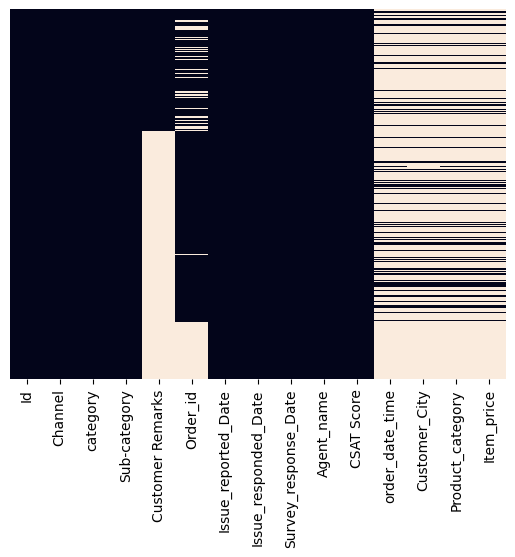

In [34]:
sns.heatmap(data_with_orders.isnull(), yticklabels=False, cbar=False)

Да данном графике видны, в частности, пропущенные значения в столбцах с комментарием пользователя и идентификатором заказа, которые появились после вертикальной интеграции первых трех таблиц. А по данным заказа мы видим большое количество пропусков. Но там, где нет идентификатора заказа, нет и никакой информации про сам заказ, что логично.



### Добавление данных менеджеров


Перейдем к последней таблице нашего набора - данным об операторах технической поддержки. Как всегда первым делом прочтем и выведем таблицу:

In [35]:
agent_data = pd.read_csv(
    "https://raw.githubusercontent.com/koroteevmv/ML_course/main/ML5.1%20data%20integration/data/agents.csv",
    index_col=0,
)
agent_data.head()


,Agent,Supervisor,Manager,Tenure Bucket,Shift
0,Aaron Edwards,Mia Patel,Emily Chen,61-90,Evening
1,Aaron Romero,Mason Gupta,Jennifer Nguyen,On Job Training,Morning
2,Abigail Gonzalez,Jacob Sato,Jennifer Nguyen,On Job Training,Morning
3,Adam Barnett,Abigail Suzuki,Jennifer Nguyen,On Job Training,Morning
4,Adam Hammond,Olivia Suzuki,John Smith,31-60,Morning


В этой таблице собрана информация о более чем 1300 работниках технической поддержки, которые обрабатывают обращения клиентов. У каждого оператора есть руководитель и менеджер, а также тип контракта и вид смены. В нашей основной таблице есть поле с именем оператора. Похоже, что именно по нему и надо будет проводить соединение. Но для начала нужно убедиться, что в этой новой таблице имя оператора уникальное. Для этого проведем группировку по имени оператора и выведем количество значений по остальным столбцам:

In [36]:
agent_data.groupby(["Agent"]).agg("count").head(20)

,Supervisor,Manager,Tenure Bucket,Shift
Agent,,,,
Aaron Edwards,1,1,1,1
Aaron Romero,1,1,1,1
Abigail Gonzalez,1,1,1,1
Adam Barnett,1,1,1,1
Adam Hammond,1,1,1,1
Adam Henderson,1,1,1,1
Adam Hernandez,1,1,1,1
Adam Schwartz,1,1,1,1
Adam Torres,1,1,1,1


Видно, что каждому имени оператора соответствует только одно значение по всем другим столбцам

Однако, в нашей основной таблице операторы названы через инициалы. Давайте в этой таблице также приведем имя оператора к нужной форме:

In [37]:
agent_data["Agent_name"] = agent_data["Agent"].apply(
    lambda x: x.split()[0][0] + ". " + x.split()[1] if isinstance(x, str) else np.NAN
)

Теперь надо сравнить имена операторов в этой и основной таблице. Опять воспользуемся группировкой:

In [38]:
agent_data.groupby(["Agent_name"]).agg("first").head(20)

,Agent,Supervisor,Manager,Tenure Bucket,Shift
Agent_name,,,,,
A. Adams,Adriana Adams,Sophia Sato,John Smith,0-30,Morning
A. Aguilar,Andrew Aguilar,Nathan Patel,Emily Chen,On Job Training,Evening
A. Barnett,Adam Barnett,Abigail Suzuki,Jennifer Nguyen,On Job Training,Morning
A. Barrett,Andrew Barrett,Elijah Yamaguchi,John Smith,>90,Evening
A. Barron,Alexandra Barron,Austin Johnson,Jennifer Nguyen,On Job Training,Evening
A. Beck,Andrea Beck,Evelyn Kimura,Jennifer Nguyen,On Job Training,Evening
A. Bell,Amy Bell,Wyatt Kim,Jennifer Nguyen,On Job Training,Evening
A. Benjamin,Amanda Benjamin,Amelia Tanaka,Emily Chen,>90,Morning
A. Berry,Amy Berry,Elijah Yamaguchi,John Smith,>90,Evening


А вот такая же группировка по основной таблице:

In [39]:
data_123.groupby(["Agent_name"]).agg("count").head(20)

,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,CSAT Score
Agent_name,,,,,,,,,,
A. Adams,215,215,215,215,70,175,215,215,215,215
A. Aguilar,31,31,31,31,11,19,31,31,31,31
A. Barnett,56,56,56,56,22,41,56,56,56,56
A. Barrett,50,50,50,50,16,35,50,50,50,50
A. Barron,25,25,25,25,9,18,25,25,25,25
A. Beck,70,70,70,70,17,51,70,70,70,70
A. Bell,20,20,20,20,10,18,20,20,20,20
A. Benjamin,64,64,64,64,22,48,64,64,64,64
A. Berry,135,135,135,135,62,89,135,135,135,135


In [40]:
data_123.groupby(["Agent_name"]).agg("count").head(20)

,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,CSAT Score
Agent_name,,,,,,,,,,
A. Adams,215,215,215,215,70,175,215,215,215,215
A. Aguilar,31,31,31,31,11,19,31,31,31,31
A. Barnett,56,56,56,56,22,41,56,56,56,56
A. Barrett,50,50,50,50,16,35,50,50,50,50
A. Barron,25,25,25,25,9,18,25,25,25,25
A. Beck,70,70,70,70,17,51,70,70,70,70
A. Bell,20,20,20,20,10,18,20,20,20,20
A. Benjamin,64,64,64,64,22,48,64,64,64,64
A. Berry,135,135,135,135,62,89,135,135,135,135


Теперь можно приступать к соединению. Воспользуемся функцией join:

In [41]:
data_with_agents = data_with_orders.join(agent_data, rsuffix="_1", how="left")
data_with_agents.head()


,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,...,order_date_time,Customer_City,Product_category,Item_price,Agent,Supervisor,Manager,Tenure Bucket,Shift,Agent_name_1
0,8c910188-c387-4a1b-8d90-24379ec8c047,Inbound,Returns,Reverse Pickup Enquiry,Very happy,NaN,2023-08-04 19:10:00,2023-08-04 19:13:00,2023-08-04,J. Blackwell,...,NaN,NaN,NaN,NaN,Aaron Edwards,Mia Patel,Emily Chen,61-90,Evening,A. Edwards
1,99d5ee06-8d2a-4754-bd17-ed235c70bf33,Inbound,Returns,Return request,Thoda jalfi replacement approve kijiye mera,89e6448f-9a48-4892-a09c-b47e0d8a87fe,2023-08-18 09:11:00,2023-08-18 09:18:00,2023-08-18,M. Wilson,...,14/08/2023 00:42,NAYAGARH,Electronics,1499.0,Aaron Romero,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,A. Romero
2,336020c5-dc97-488f-8f16-ed33ed04e5fc,Inbound,Returns,Damaged,Technician not visit the RO and without visit ...,15476f9a-35cc-4f33-ae33-8d9cd6ecb1a6,2023-08-22 07:15:00,2023-08-22 08:15:00,2023-08-22,A. Smith,...,NaN,NaN,NaN,NaN,Abigail Gonzalez,Jacob Sato,Jennifer Nguyen,On Job Training,Morning,A. Gonzalez
3,22c5643c-3d54-487c-8863-c57e198a70be,Inbound,Returns,Fraudulent User,madam ne mera problem solve kar Diya hai . t...,NaN,2023-08-14 09:21:00,2023-08-14 09:27:00,2023-08-14,A. Berry,...,NaN,NaN,NaN,NaN,Adam Barnett,Abigail Suzuki,Jennifer Nguyen,On Job Training,Morning,A. Barnett
4,abd330a8-f3e2-4b7a-b14a-4ed35c4ec023,Inbound,Returns,Fraudulent User,Gjjjzjxgxteuhxgxe5xhxh,NaN,2023-08-03 08:18:00,2023-08-03 08:23:00,2023-08-03,S. Taylor,...,NaN,NaN,NaN,NaN,Adam Hammond,Olivia Suzuki,John Smith,31-60,Morning,A. Hammond


При анализе первых строк датасета проблемы не видно, но давайте изобразим на графике пропущенные значения:

<Axes: >

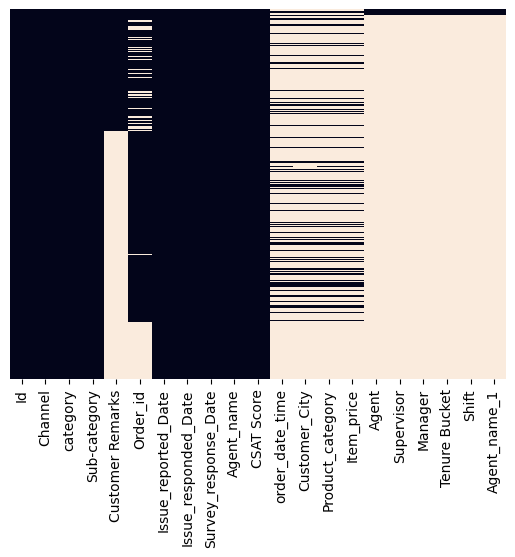

In [42]:
sns.heatmap(data_with_agents.isnull(), yticklabels=False, cbar=False)

Здесь мы видим явно аномальную картину

Дело в том, что функция join по умолчанию проводит соединение по индексу двух датафреймов в качестве ключа. То есть в нашем случае, по номеру строки. Нам же нужно указать название определенного столбца. Для такого режима соединения больше подходит функция merge:

In [43]:
data_with_agents = data_with_orders.merge(
    agent_data, how="left", on="Agent_name", copy=False
)
data_with_agents.head()


,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score,order_date_time,Customer_City,Product_category,Item_price,Agent,Supervisor,Manager,Tenure Bucket,Shift
0,8c910188-c387-4a1b-8d90-24379ec8c047,Inbound,Returns,Reverse Pickup Enquiry,Very happy,NaN,2023-08-04 19:10:00,2023-08-04 19:13:00,2023-08-04,J. Blackwell,1,NaN,NaN,NaN,NaN,James Blackwell,Jackson Park,William Kim,On Job Training,Evening
1,99d5ee06-8d2a-4754-bd17-ed235c70bf33,Inbound,Returns,Return request,Thoda jalfi replacement approve kijiye mera,89e6448f-9a48-4892-a09c-b47e0d8a87fe,2023-08-18 09:11:00,2023-08-18 09:18:00,2023-08-18,M. Wilson,4,14/08/2023 00:42,NAYAGARH,Electronics,1499.0,Mark Wilson,Scarlett Chen,John Smith,0-30,Morning
2,336020c5-dc97-488f-8f16-ed33ed04e5fc,Inbound,Returns,Damaged,Technician not visit the RO and without visit ...,15476f9a-35cc-4f33-ae33-8d9cd6ecb1a6,2023-08-22 07:15:00,2023-08-22 08:15:00,2023-08-22,A. Smith,5,NaN,NaN,NaN,NaN,Anthony Smith,Mia Patel,John Smith,>90,Morning
3,22c5643c-3d54-487c-8863-c57e198a70be,Inbound,Returns,Fraudulent User,madam ne mera problem solve kar Diya hai . t...,NaN,2023-08-14 09:21:00,2023-08-14 09:27:00,2023-08-14,A. Berry,5,NaN,NaN,NaN,NaN,Amy Berry,Elijah Yamaguchi,John Smith,>90,Evening
4,abd330a8-f3e2-4b7a-b14a-4ed35c4ec023,Inbound,Returns,Fraudulent User,Gjjjzjxgxteuhxgxe5xhxh,NaN,2023-08-03 08:18:00,2023-08-03 08:23:00,2023-08-03,S. Taylor,5,NaN,NaN,NaN,NaN,Sarah Taylor,Carter Park,Jennifer Nguyen,On Job Training,Morning


Не доверяя глазам при анализе первых строк датасета, выведем диаграмму пропущенных значений:

<Axes: >

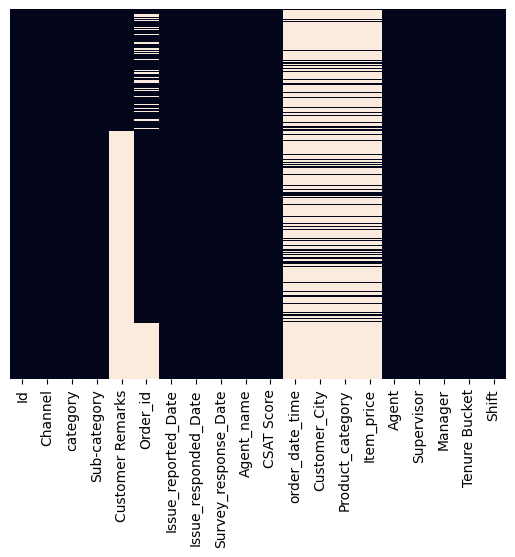

In [44]:
sns.heatmap(data_with_agents.isnull(), yticklabels=False, cbar=False)

Картина сильно изменилась. Теперь отсутствующих значений совсем нет:

Однако, если отследить формы датасетов, можно заметить что в итоге получилось сильно больше строк, чем было в левой таблице. При проведении левого соединения такое может случиться только если в правой таблице есть несколько записей, соответствующих по ключу одной записи в левой таблице. Давайте проверим уникальность ключа в правой таблице:

In [45]:
agent_data.Agent_name.value_counts()

Agent_name
J. Moore        6
A. Brown        4
M. Smith        4
D. Smith        4
K. Martin       4
               ..
J. Meadows      1
J. Edwards      1
J. Schroeder    1
J. Robertson    1
Z. Simpson      1
Name: count, Length: 1221, dtype: int64

Получается, что после сокращения имен уникальность имени оператора потеряна

Одному и тому же инициалу может соответствовать несколько разных полных имен:

In [46]:
agent_data[agent_data.Agent_name == "J. Moore"]

,Agent,Supervisor,Manager,Tenure Bucket,Shift,Agent_name
468,Jacob Moore,Ava Wong,Jennifer Nguyen,On Job Training,Morning,J. Moore
529,Jenna Moore,Aiden Patel,John Smith,>90,Morning,J. Moore
542,Jennifer Moore,Nathan Patel,Jennifer Nguyen,On Job Training,Evening,J. Moore
612,Jon Moore,Ava Wong,William Kim,On Job Training,Evening,J. Moore
617,Jonathan Moore,Zoe Yamamoto,John Smith,>90,Morning,J. Moore
654,Juan Moore,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,J. Moore


Что же делать в такой ситуации? Давайте посмотрим, какое количество записей в правой таблице соответствует каждой строке в левой. Для этого соединим левую таблицу со сверткой правой таблицы по именам:

In [47]:
data_with_agent_numbers = data_with_orders.merge(
    agent_data.Agent_name.value_counts(),
    how="left",
    left_on="Agent_name",
    right_index=True,
)


И выведем в этой таблице статистику по распределению количества строк:

In [48]:
data_with_agent_numbers["count"].value_counts()

count
1    68749
2    11326
3     3695
4     1843
6      294
Name: count, dtype: int64

Мы видим, что все же абсолютному большинству строк основной таблицы соответствует единственная запись в таблице операторов. То есть дублирование строк - это скорее исключение. Поэтому мы можем добавить в датасет информацию об операторах в том случае, если сопоставление однозначное. А для остальных записей, которым соответствует несколько возможных имен, будут стоять пропуски. Как и положено в случае неопределенности данных.

Для этого удалим данные об имени оператора у тех строк, где соответствие множественное:

In [49]:
data_with_agent_numbers['Agent_name'] = data_with_agent_numbers.Agent_name.where(
    data_with_agent_numbers['count'] == 1, np.NAN
)

Теперь можно провести соединение:

In [50]:
data_with_agents = data_with_agent_numbers.merge(
    agent_data, how="left", on="Agent_name"
)
data_with_agents.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Id                    85907 non-null  object        
 1   Channel               85907 non-null  object        
 2   category              85907 non-null  object        
 3   Sub-category          85907 non-null  object        
 4   Customer Remarks      28425 non-null  object        
 5   Order_id              66661 non-null  object        
 6   Issue_reported_Date   85907 non-null  datetime64[ns]
 7   Issue_responded_Date  85907 non-null  datetime64[ns]
 8   Survey_response_Date  85907 non-null  datetime64[ns]
 9   Agent_name            68749 non-null  object        
 10  CSAT Score            85907 non-null  int64         
 11  order_date_time       16951 non-null  object        
 12  Customer_City         16817 non-null  object        
 13  Product_category

Видим, что теперь количество строк не увеличилось

Осталось удалить лишние столбцы, которые мы вводили в таблицу для проведения служебных операций:

In [51]:
data_with_agents = data_with_agents.drop(["count", "Agent_name"], axis=1)

И визуализируем пропуски в датасете:

<Axes: >

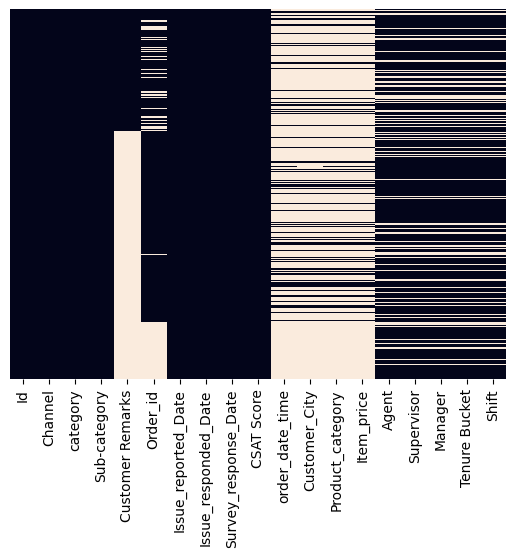

In [52]:
sns.heatmap(data_with_agents.isnull(), yticklabels=False, cbar=False)

В итоге мы получили датасет, содержащий максимум информации из исходных таблиц. Этот датасет пригоден к анализу и после очистки данных его можно использовать для машинного обучения.

### Задания для самостоятельного выполнения

1. При выполнении вертикального объединения убедитесь в отсутствии дубликатов данных.

2. При горизонтальной интеграции первой и второй таблицы выведите по каждому столбцу гистограмму распределения или плотность распределения, чтобы убедиться, что признаки выражаются по соотносимым шкалам.
3. При выполнении третьего задания убедитесь более явно, что обильное количество пропущенных значений не является ошибкой объединения. Проведите больше, чем одну точечную проверку.
4. При выполнении третьего задания попробуйте использовать разные виды соединений. Как это отражается на структуре датасета?
5. Изучите документацию pandas в части описания методов merge и join.
6. Познакомьтесь с форматом представления дат strftime.

---
1. При выполнении вертикального объединения убедитесь в отсутствии дубликатов данных.

In [53]:
# Дубликатов нет
pd.concat([data1, data2]).duplicated().any()

False

---
2. При горизонтальной интеграции первой и второй таблицы выведите по каждому столбцу гистограмму распределения или плотность распределения, чтобы убедиться, что признаки выражаются по соотносимым шкалам.

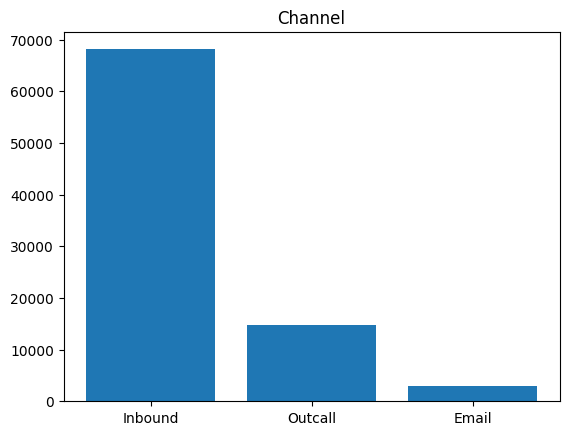

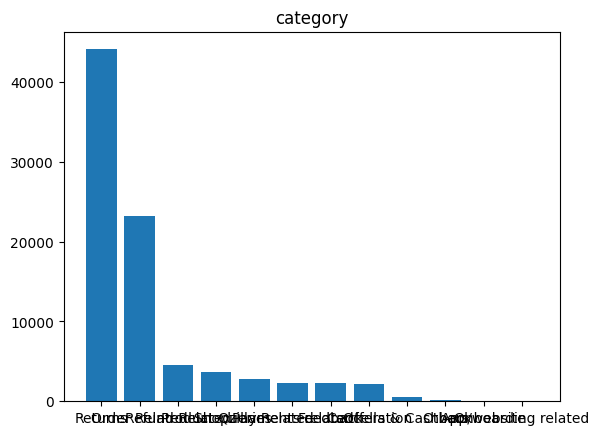

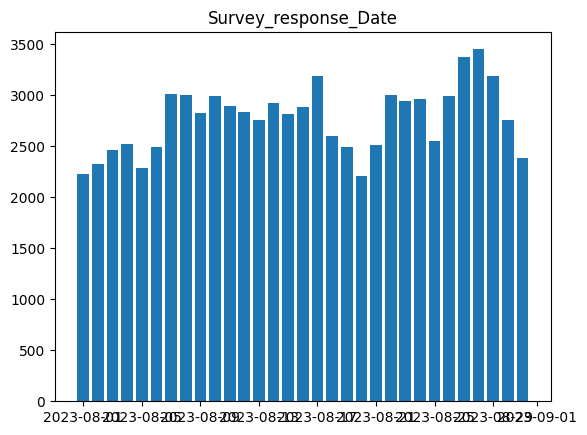

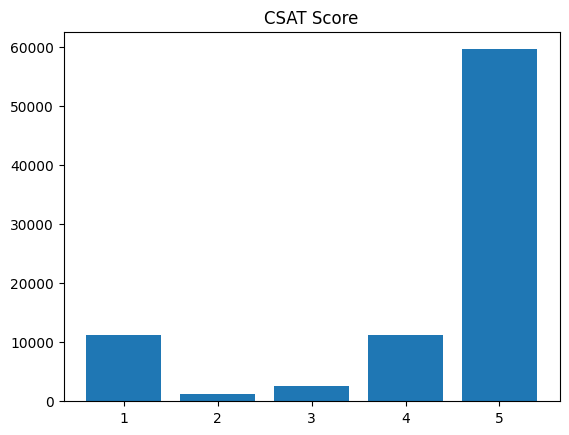

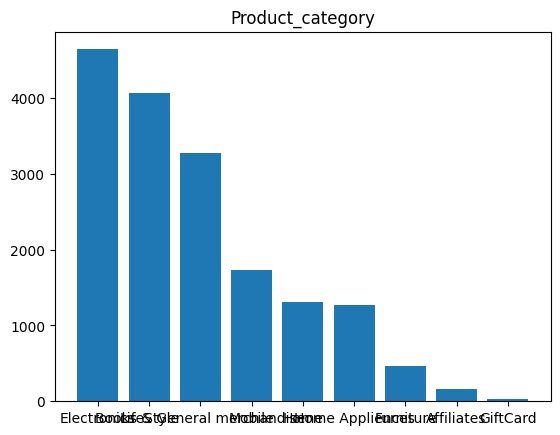

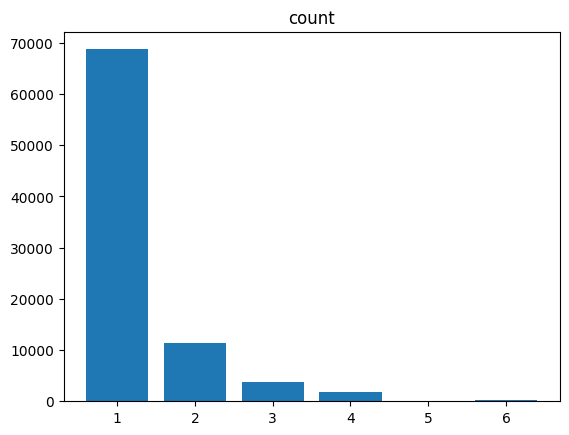

In [54]:
# При горизонтальной интеграции (merge) выводим гистограммы столбцов
for col in data_with_agent_numbers.columns:
    x, h = zip(*data_with_agent_numbers[col].value_counts().items())
    if not (0 < len(x) < 50):
        continue
    fig, ax = plt.subplots()
    ax.set_title(col)
    ax.bar(x, h)


---
3. При выполнении третьего задания убедитесь более явно, что обильное количество пропущенных значений не является ошибкой объединения. Проведите больше, чем одну точечную проверку.

Сравним количество уникальных заказов

In [55]:
# В data_with_orders
len(data_with_orders.Order_id.unique())


66662

In [56]:
# В orders_data
len(orders_data.Order_id.unique())


34103

Видно что в orders_data их сильно меньше, будет много отсутсвующих строк и это нормально

In [57]:
for order in list(set(data_with_orders.Order_id) - set(orders_data.Order_id))[:10]:
    # Посмотрим на некоторые заказы
    print(order, any(order == orders_data.Order_id))


574b61af-d9f9-4211-b6af-112b7d41f960 False
5ed5202e-af23-43a3-bd2e-f006d576c566 False
aba62f05-6168-4c79-b1c8-047f086e7c73 False
e6bedbb1-03bf-49d7-b3ad-41d676ba101b False
9c8bc392-e569-48c8-9093-bcd0770a1eab False
40d1a356-6f87-4ed9-a852-4ca9aa912894 False
3d4336d7-bdc7-4777-bfb0-7ca366cdfe37 False
8e1e2e63-7b45-4e4c-904a-4e276c5db31a False
a8088118-6692-4baf-b57c-fe4d5da730c9 False
1cf7dd4c-921d-4740-beba-b37df5212c35 False


---
4. При выполнении третьего задания попробуйте использовать разные виды соединений. Как это отражается на структуре датасета?

In [58]:
# Использование right_join приводит к тому что почти все столбцы заполенны nan
data_with_orders = data_123.merge(orders_data, on="Order_id", how="right")
data_with_orders.head()


,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score,order_date_time,Customer_City,Product_category,Item_price
0,NaN,NaN,NaN,NaN,NaN,53465d50-a568-48a9-b96e-ee2a0524fee8,NaT,NaT,NaT,NaN,NaN,14/08/2023 18:54,NEW DELHI,Books & General merchandise,144.0
1,NaN,NaN,NaN,NaN,NaN,57d64c28-e3dc-49bd-8e8a-8e24572c6b59,NaT,NaT,NaT,NaN,NaN,30/07/2023 21:43,HAJIPUR,Home,445.0
2,NaN,NaN,NaN,NaN,NaN,55d4e1bb-e148-437f-aa83-3bfbae939155,NaT,NaT,NaT,NaN,NaN,10/07/2023 21:20,HYDERABAD,LifeStyle,399.0
3,NaN,NaN,NaN,NaN,NaN,509803e9-4c15-4db4-bbe7-fc1e12b6c6cc,NaT,NaT,NaT,NaN,NaN,08/08/2023 16:40,JASPUR,Mobile,32999.0
4,NaN,NaN,NaN,NaN,NaN,5cfbe41f-ffcc-4fcf-8520-94bb61dee14e,NaT,NaT,NaT,NaN,NaN,07/08/2023 08:29,JHAJJAR,Electronics,1499.0


In [59]:
# При inner_join почти нет nan
data_with_orders = data_123.merge(orders_data, on="Order_id", how="inner")
data_with_orders.head()

,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score,order_date_time,Customer_City,Product_category,Item_price
0,99d5ee06-8d2a-4754-bd17-ed235c70bf33,Inbound,Returns,Return request,Thoda jalfi replacement approve kijiye mera,89e6448f-9a48-4892-a09c-b47e0d8a87fe,2023-08-18 09:11:00,2023-08-18 09:18:00,2023-08-18,M. Wilson,4,14/08/2023 00:42,NAYAGARH,Electronics,1499.0
1,9a9432e9-948b-4eaa-86fc-4c2ccb877fd0,Inbound,Order Related,Order status enquiry,Best,b922ec6e-d3d2-4522-be34-d8c89e45f4c4,2023-08-26 07:49:00,2023-08-26 07:57:00,2023-08-26,D. Perez,5,19/08/2023 06:55,SRINAGAR,Electronics,999.0
2,406d7a47-7dc6-4504-be9b-5ff044a7bb3a,Inbound,Order Related,Delayed,Change your delivery partner to some responsible,045e5c18-1211-4d5e-a7cd-c2af955c80d6,2023-08-24 14:55:00,2023-08-25 14:20:00,2023-08-25,S. Huber,1,17/08/2023 20:55,SURAT,Mobile,26935.0
3,a4365adc-b4cb-4de6-9a6d-9ca56d07030b,Inbound,Order Related,Delayed,Great effort,96db2a63-2d31-4a54-af49-d02dcc9efab0,2023-08-09 08:47:00,2023-08-09 12:20:00,2023-08-09,J. Gibson,5,29/07/2023 12:42,RAJOURI,Books & General merchandise,253.0
4,edddcc47-a99c-4fa2-8c36-3acb1361a98e,Inbound,Order Related,Priority delivery,Shopzilla customer care service was very good ...,15fe6fa0-07d1-4568-a78e-bb5760771d1e,2023-08-11 21:45:00,2023-08-11 21:48:00,2023-08-11,C. Crawford,5,10/08/2023 11:32,BHUJ,Books & General merchandise,96.0


In [60]:

data_with_orders.isna().any()

Id                      False
Channel                 False
category                False
Sub-category            False
Customer Remarks         True
Order_id                False
Issue_reported_Date     False
Issue_responded_Date    False
Survey_response_Date    False
Agent_name              False
CSAT Score              False
order_date_time         False
Customer_City            True
Product_category         True
Item_price               True
dtype: bool

In [61]:
# При outer_join почти появились пустые столбцы
data_with_orders = data_123.merge(orders_data, on="Order_id", how="outer")
data_with_orders.head()


,Id,Channel,category,Sub-category,Customer Remarks,Order_id,Issue_reported_Date,Issue_responded_Date,Survey_response_Date,Agent_name,CSAT Score,order_date_time,Customer_City,Product_category,Item_price
0,8c910188-c387-4a1b-8d90-24379ec8c047,Inbound,Returns,Reverse Pickup Enquiry,Very happy,NaN,2023-08-04 19:10:00,2023-08-04 19:13:00,2023-08-04,J. Blackwell,1.0,NaN,NaN,NaN,NaN
1,22c5643c-3d54-487c-8863-c57e198a70be,Inbound,Returns,Fraudulent User,madam ne mera problem solve kar Diya hai . t...,NaN,2023-08-14 09:21:00,2023-08-14 09:27:00,2023-08-14,A. Berry,5.0,NaN,NaN,NaN,NaN
2,abd330a8-f3e2-4b7a-b14a-4ed35c4ec023,Inbound,Returns,Fraudulent User,Gjjjzjxgxteuhxgxe5xhxh,NaN,2023-08-03 08:18:00,2023-08-03 08:23:00,2023-08-03,S. Taylor,5.0,NaN,NaN,NaN,NaN
3,fba1631d-e5c9-4b85-86e7-e5417b4ffee4,Inbound,Order Related,Seller Cancelled Order,Very bad experience,NaN,2023-08-04 16:29:00,2023-08-04 17:39:00,2023-08-04,T. Young,1.0,NaN,NaN,NaN,NaN
4,d9b841f5-a306-4775-bc77-f1e2d64312a0,Inbound,Order Related,Order status enquiry,"Sir,Regarding my order of 300g Chai seeds The ...",NaN,2023-08-27 10:03:00,2023-08-27 17:52:00,2023-08-27,B. Nunez,1.0,NaN,NaN,NaN,NaN


---
### Контрольные вопросы
1. Какие ошибки могут произойти при горизонтальной интеграции данных?
    - Дублирование строк при множественном соотношении ключей

2. Какими средствами можно проверить совпадение шкал измерения атрибута в разных датасетах?
    - Можно построить гистограммы или плотности распределения

3. Какие ошибки могут произойти при вертикальной интеграции данных?
    - Дублирование строк с данными
    - Несоответсвие количества колонок
    - Несоответсвие названий колонок
4. Чем отличаются методы merge и join в библиотеке pandas?
    - `join` объединяет по индексам, `merge` по столбцу
5. Какие бывают виды соединения таблиц и в каких случая их нужно применять? Приведите по два примера на каждый вид объединения.
    - LEFT JOIN:
        - Возвращает все строки из левой таблицы и соответствующие строки из правой таблицы. Если нет совпадений, возвращается NULL.
        - Применяется, когда нужно включить все строки из одной таблицы, независимо от наличия совпадений в другой таблице.
    - RIGHT JOIN:
        - Возвращает все строки из правой таблицы и соответствующие строки из левой таблицы. Если нет совпадений, возвращается NULL.
        - Редко используется, так как можно переписать запрос с использованием LEFT JOIN.
    - INNER JOIN:
        - Этот тип объединения возвращает только те строки, которые имеют совпадения в обеих таблицах.
        - Применяется, когда требуется получить только те строки, которые имеют соответствующие записи в обеих таблицах.
    - FULL (OUTER) JOIN:
        - Возвращает все строки из обеих таблиц, соединяя их по условию объединения. Если нет совпадений, возвращаются NULL-значения.
        - Применяется, когда нужно объединить данные из двух таблиц, сохраняя все строки из обеих таблиц.